# Global Imports

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
from collections import Counter
random.seed(42)

# Local Imports

In [2]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [3]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "Mongo"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\checkpoints\Lake_epoch82_trainacc0.9782_valacc0.99419_Tloss0.0052215_Vloss0.0015499_lr0.0005219339999999999.pkl"

# Define Paths
Workspace

In [4]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [5]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-f]+)-([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)

len(image_paths)

1149

# Helper Functions

In [6]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [7]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels From File Names

In [8]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    
    class_counts[u_hexvalue] += 1
    
    
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))

len(labels), len(image_paths)

(1139, 1139)

In [9]:
Counter(labels)

Counter({'u3a': 56,
         'u61': 54,
         'u31': 54,
         'u3bb': 49,
         'u2e': 49,
         'u28': 48,
         'u29': 48,
         'u2203': 38,
         'u3bc': 37,
         'u2200': 26,
         'u68': 20,
         'u34': 20,
         'u6f': 20,
         'u38': 20,
         'u62': 20,
         'u77': 20,
         'u71': 20,
         'u7a': 20,
         'u39': 20,
         'u72': 20,
         'u76': 20,
         'u73': 20,
         'u30': 20,
         'u69': 20,
         'u6c': 20,
         'u6d': 20,
         'u74': 20,
         'u6e': 20,
         'u35': 20,
         'u36': 20,
         'u6b': 20,
         'u6a': 20,
         'u37': 20,
         'u63': 20,
         'u64': 20,
         'u75': 20,
         'u66': 20,
         'u33': 20,
         'u67': 20,
         'u70': 20,
         'u79': 20,
         'u32': 20,
         'u78': 20,
         'u65': 20})

# Balance Classes Using Oversample/Undersample

In [10]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)
min_count: int = min(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count 
    for uid, count in 
    sorted_counts
}

to_undersample_counts: dict[str, int] = {
    uid: min_count
    for uid, count in 
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)


In [11]:
min_count, max_count, total_items

(20, 56, 1139)

In [12]:
#print(*to_add_counts.items())
#print(sorted([(chr(int(pair[0][1:], 16)), pair[1]) for pair in to_remove_counts.items()], key=lambda x: x[1]))

# Oversample

In [13]:
#to_add_labels: list[str] = []
#to_add_file_paths: list[str] = []
#
#while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:  
#    for label, image_path in zip(labels, image_paths):
#        remaining: int = to_add_counts[label]
#        
#        if remaining > 0:
#            to_add_labels.append(label)
#            to_add_file_paths.append(image_path)
#            to_add_counts[label] -= 1

# Undersample

In [14]:
to_keep_labels: list[str] = []
to_keep_file_paths: list[str] = []

while True in [to_add_count>0 for to_add_count in to_undersample_counts.values()]:  
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_undersample_counts[label]
        
        if remaining > 0:
            to_keep_labels.append(label)
            to_keep_file_paths.append(image_path)
            to_undersample_counts[label] -= 1

In [15]:
to_keep_labels

['u2203',
 'u68',
 'u34',
 'u6f',
 'u38',
 'u62',
 'u38',
 'u77',
 'u71',
 'u3bb',
 'u61',
 'u7a',
 'u39',
 'u72',
 'u68',
 'u3bc',
 'u72',
 'u76',
 'u73',
 'u30',
 'u3bb',
 'u69',
 'u30',
 'u6c',
 'u31',
 'u31',
 'u28',
 'u6d',
 'u3a',
 'u2e',
 'u74',
 'u3bc',
 'u61',
 'u2200',
 'u6c',
 'u69',
 'u7a',
 'u62',
 'u2e',
 'u72',
 'u6e',
 'u71',
 'u35',
 'u35',
 'u2203',
 'u61',
 'u31',
 'u3a',
 'u2200',
 'u36',
 'u3a',
 'u3bc',
 'u6b',
 'u6d',
 'u2200',
 'u76',
 'u76',
 'u36',
 'u6a',
 'u31',
 'u73',
 'u61',
 'u61',
 'u30',
 'u37',
 'u28',
 'u2203',
 'u61',
 'u63',
 'u64',
 'u6b',
 'u6c',
 'u62',
 'u61',
 'u37',
 'u28',
 'u64',
 'u73',
 'u62',
 'u61',
 'u62',
 'u75',
 'u31',
 'u66',
 'u2e',
 'u6b',
 'u63',
 'u33',
 'u2200',
 'u29',
 'u2203',
 'u36',
 'u6d',
 'u2203',
 'u73',
 'u74',
 'u67',
 'u31',
 'u28',
 'u63',
 'u37',
 'u29',
 'u76',
 'u31',
 'u6b',
 'u70',
 'u64',
 'u3a',
 'u29',
 'u61',
 'u3bb',
 'u38',
 'u76',
 'u37',
 'u2200',
 'u6a',
 'u2200',
 'u68',
 'u71',
 'u6d',
 'u69',
 'u6

In [16]:

Counter(to_keep_labels)

Counter({'u2203': 20,
         'u68': 20,
         'u34': 20,
         'u6f': 20,
         'u38': 20,
         'u62': 20,
         'u77': 20,
         'u71': 20,
         'u3bb': 20,
         'u61': 20,
         'u7a': 20,
         'u39': 20,
         'u72': 20,
         'u3bc': 20,
         'u76': 20,
         'u73': 20,
         'u30': 20,
         'u69': 20,
         'u6c': 20,
         'u31': 20,
         'u28': 20,
         'u6d': 20,
         'u3a': 20,
         'u2e': 20,
         'u74': 20,
         'u2200': 20,
         'u6e': 20,
         'u35': 20,
         'u36': 20,
         'u6b': 20,
         'u6a': 20,
         'u37': 20,
         'u63': 20,
         'u64': 20,
         'u75': 20,
         'u66': 20,
         'u33': 20,
         'u29': 20,
         'u67': 20,
         'u70': 20,
         'u79': 20,
         'u32': 20,
         'u78': 20,
         'u65': 20})

# Load Dataset

In [17]:
image_paths = to_keep_file_paths
labels = to_keep_labels
len(image_paths), len(labels)

(880, 880)

In [18]:

split_index: int = int(len(image_paths)*DATASET_SPLIT)
all_label_classes: list[str] = sorted(list(set(labels)))

In [19]:
"".join(list(map(lambda x: chr(int(x[1:], 16)), all_label_classes)))

'∀∃().0123456789:λμabcdefghijklmnopqrstuvwxyz'

In [20]:

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[:split_index], #list(image_paths[:split_index]) + to_add_file_paths,
    labels=labels[:split_index], #list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.05,
    translation_limit=0.2,
    skew_limit=0.02,
    zoom_change=1.2,
    min_zoom=0.8,
    thicken_sigma=-4.9,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=0.0,
    image_dims=(64, 64)
)




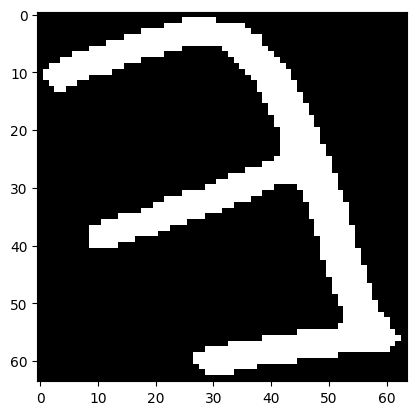

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [21]:
for im, lab in train_char_dataset:
    plt.imshow(
        rearrange(im, "1 h w -> h w")*255, 
        cmap="gray"
    )
    plt.show()
    
    print(lab)
    break

torch.Size([1, 64, 64])


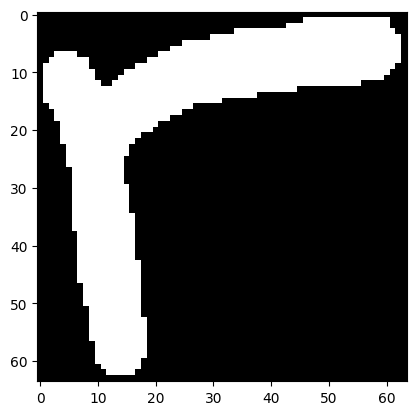

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [22]:
for im, lab in val_char_dataset:
    print(im.shape)
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [23]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

In [24]:
len(class_counts.keys())

44

# Define Model Hyperparameters

In [25]:


all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, len(all_label_classes)),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.0007224,
        "weight_decay": 0.000001
    }
]


In [26]:
len(val_dataloader)

11

# Train

In [27]:


epoch_log: EpochLogs
for epoch_log in grid_search(
    model_factory=AllCNN2D,
    all_model_parameters=all_model_parameters,
    optim_factory=AdamW,
    all_optim_params=all_optim_parameters,
    epochs=10000,
    criterion=nn.CrossEntropyLoss(),
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr_decay_window_size=10,
    lr_decay_minimum=0.0,
    scheduler_scale=0.85,
    device="cuda"
):
    train_logpoints: list[LogPoint] = epoch_log.train_logs
    val_logpoints: list[LogPoint] = epoch_log.val_logs
    
    
    train_count: int = 0
    val_count: int = 0
    
    train_losses_tally: float = 0.0
    val_losses_tally: float = 0.0
    
    train_correct_tally: int = 0
    val_correct_tally: int = 0
    
    for log_point in train_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        
        train_is_correct = y_hat_pred==y_pred
        train_correct_tally += torch.sum(train_is_correct)
        
        train_losses_tally += torch.sum(log_point.loss)
        
        train_count += len(y_hat_pred)
        
    for log_point in val_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()
        print(y_hat_pred, y_pred)
        val_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        val_losses_tally += torch.sum(log_point.loss)
        
        val_count += len(y_hat_pred)
        
    train_accuracy: float = train_correct_tally/train_count
    val_accuracy: float = val_correct_tally/val_count
    
    train_loss: float = train_losses_tally/train_count
    val_loss: float = val_losses_tally/val_count
    
    cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
    
    model_checkpoint_path: str = os.path.join(
        model_save_dirpath,
        f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}_Tloss{train_loss:.5}_Vloss{val_loss:.5}_lr{cur_learning_rate}.pkl"
    )
    
    with open(model_checkpoint_path, "wb") as f:
        torch.save(epoch_log.model.state_dict(), f)
    
    print(f"Train Accuracy      : {train_accuracy}")
    print(f"Val Accuracy        : {val_accuracy}")
    print(f"Loss                : {train_loss}")
    print(f"Val Loss            : {val_loss}")
    print(f"Learning Rate       : {cur_learning_rate}")
    
    log(
        epoch_log.epoch,
        train_accuracy,
        train_loss,
        val_accuracy,
        val_loss,
        cur_learning_rate
    )

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

Validating Model...: 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]


tensor([12, 14, 19,  4, 16, 22, 14, 31,  5, 16, 42,  3, 26, 19,  4,  5]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([ 4, 16, 35, 23, 16, 25, 14, 16, 35, 24, 24,  8, 19, 20, 39, 24]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([22, 22, 33, 24, 31, 20, 39, 21, 36, 14, 26,  5, 22,  0, 27, 14]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 25, 28, 22,  5, 28,  0, 22,  3, 14, 18, 36, 25, 14]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([19, 19, 20, 24,  8, 24, 21, 23, 19, 22, 36,  0, 31,  5, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([42, 41,  2, 24, 27, 36,  8,  1,  2,  5, 19, 18,  0, 28, 10, 16]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 12, 25, 42, 31,  0,  4, 14, 25, 10, 16, 28,  5,  4,  3,  0]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


tensor([35, 12,  0,  4, 33, 11,  5, 31,  5, 30, 19, 30,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 17,  0, 32, 30, 27, 10, 14,  8, 19, 20, 41, 24]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 22, 37, 10, 14, 20, 39, 22, 36,  3, 26, 31, 41,  0, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39,  0, 28, 30, 32, 38,  0, 22,  0,  5, 34, 10, 38, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 11,  8, 35, 21, 41,  0, 22, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([ 0, 41, 28, 24, 35, 36,  8, 27,  2, 31, 19, 34,  0, 28, 10, 17]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 20,  0,  0, 24, 38, 26,  5, 19, 37, 33, 28, 31, 43,  3,  0]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


tensor([35, 12,  0, 12, 33, 13, 32, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 24]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 22, 36, 32, 26, 31, 41, 40, 35, 32]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40, 28, 30, 32, 38, 38, 22,  0, 32, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36, 32, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27,  2, 31, 11, 34,  0, 28, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33, 28, 31, 43,  3, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 38, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 11,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27,  2, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43,  3, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 38, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 38, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  1, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 38, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


tensor([35, 12, 40, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  1, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 29, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35, 32]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0, 32, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36, 32, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43, 32, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27,  2, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40,  5, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30,  5, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


tensor([35, 12, 19, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 38, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 38, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Validating Model...: 100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0,  2, 19, 43, 31]) tensor([35, 12,  0, 12, 33, 13,  5, 33, 32, 30, 25,  0, 29, 19, 43, 31])
tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23]) tensor([43, 30, 27, 41, 33, 40, 32, 30, 27, 10, 23, 13, 19, 20, 42, 23])
tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5]) tensor([30, 13, 37, 10, 14, 20, 39, 13, 36, 32, 26, 31, 41, 40, 35,  5])
tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32]) tensor([36, 20, 39, 40,  9, 30, 32, 38, 40, 22,  0,  5, 34, 10, 40, 32])
tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20]) tensor([11, 19, 20, 13,  8, 23, 21, 41, 25, 37, 36,  5, 14, 31, 36, 20])
tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33]) tensor([25, 41, 28, 24, 35, 36,  8, 27, 29, 31, 11, 34, 40,  9, 42, 33])
tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,  9, 31, 43, 42, 40]) tensor([26, 35, 40, 25, 24, 38, 43,  5, 11, 37, 33,

Training model...:   2%|▏         | 1/44 [00:03<02:11,  3.05s/it]


KeyboardInterrupt: 

# Inference

In [ ]:
model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,#0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch26_trainacc0.71327_valacc0.99057_Tloss0.072851_Vloss0.0056362_lr0.0007224999999999999.pkl"
    }
)

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

In [ ]:
for char, label in val_char_dataset:
    plt.imshow(char[0, :, :])
    plt.show()
    pred: torch.Tensor = model.forward(char.unsqueeze(0)).squeeze()
    pred_index: int = torch.argmax(pred).item()
    print(chr(int(all_label_classes[pred_index][1:], base=16)))

TypeError: pad() got an unexpected keyword argument 'mode'